<a href="https://colab.research.google.com/github/orannahum/Image-Segmentation/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial No. 3

## 1. Import Packages

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import numpy as np
import itertools
import tensorflow as tf



## 2. Load Data

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete9C0QFP/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete9C0QFP/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
Train dataset size: 2576
Validation dataset size: 1104
Test dataset size: 3669
['file_name', 'image', 'label', 'segmentation_mask', 'species']
Label: 6
Species: 0
Image shape: (333, 500, 3)
Image values: 0-255
Segmentation mask shape: (333, 500, 1)
Segmentation mask values: {1, 2, 3}


file_name  ... species
0                     b'Birman_140.jpg'  ...       0
1               b'Russian_Blue_169.jpg'  ...       0
2  b'american_pit_bull_terrier_102.jpg'  ...       1
3            b'wheaten_terrier_172.jpg'  ...       1
4          b'British_Shorthair_155.jpg'  ...       0
5                      b'boxer_158.jpg'  ...       1
6  b'american_pit_bull_terrier_109.jpg'  ...       1
7     b'english_cocker_spaniel_172.jpg'  ...       1
8                 b'leonberger_161.jpg'  ...       1
9               b'basset_hound_158.jpg'  ...       1

[10 rows x 5 columns]
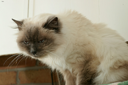
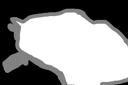
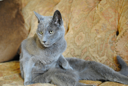
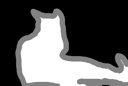
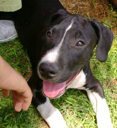
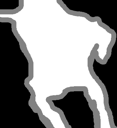
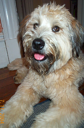
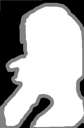
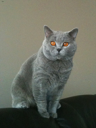
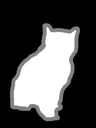
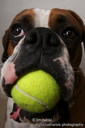
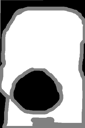
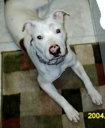
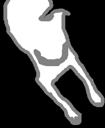
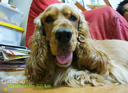
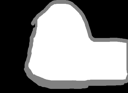
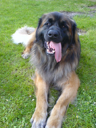
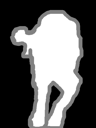
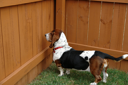

In [4]:
(raw_train_dataset, raw_test_dataset), dataset_info = (
    tfds.load('oxford_iiit_pet', split=('train', 'test'), with_info=True))
#raw_train_dataset = tf.image.resize_images(raw_train_dataset, (224, 224))

# Since there's no validation/training split, we'll take 30%
validation_count = int(0.3 * len(raw_train_dataset))
raw_validation_dataset = raw_train_dataset.take(validation_count)
raw_train_dataset = raw_train_dataset.skip(validation_count)

# Check size of dataset
print(f'Train dataset size: {len(raw_train_dataset)}')
print(f'Validation dataset size: {len(raw_validation_dataset)}')
print(f'Test dataset size: {len(raw_test_dataset)}')

# Visualize the structure of the data
for example in raw_train_dataset.take(1):
  print(list(example.keys()))
  image = example["image"]
  seg_mask = example["segmentation_mask"]
  all_values = set(seg_mask.numpy().flatten())
  image_values = set(image.numpy().flatten())

  print(f'Label: {example["label"]}')
  print(f'Species: {example["species"]}')
  print(f'Image shape: {image.shape}')
  print(f'Image values: {min(image_values)}-{max(image_values)}')
  print(f'Segmentation mask shape: {seg_mask.shape}')
  print(f'Segmentation mask values: {all_values}')

# Visualize a few samples from the dataset

# Segmentation values are 1 (Inside), 2 (Outside) and 3 (Edge)
# To visualize, we transform these to white, black and gray (respectively)
def to_visible_segmentation_mask(image_tensor):
    shifted = (image_tensor-1)
    return 64 * shifted * shifted - 319 * shifted + 255

def update_segmentation_mask(data_point):
  data_point['segmentation_mask'] = to_visible_segmentation_mask(data_point['segmentation_mask'])
  return data_point

tfds.as_dataframe(raw_train_dataset.take(10).map(update_segmentation_mask), dataset_info)

In [5]:
# Before we start, we'll transform the dataset to (x, y) pairs and an easier
# format to use
@tf.function
def normalize_datapoint(datapoint):
  input_image = datapoint['image']
  # Reduce one so the classes are [0, 1, 2] instead of [1, 2, 3]
  input_mask = datapoint['segmentation_mask'] - 1

  # Here we can do any preprocessing on the data
  input_image = tf.image.resize(input_image,(256,256))
  input_mask = tf.image.resize(input_mask,(256,256))

  return input_image, input_mask

train_dataset = raw_train_dataset.map(normalize_datapoint)
validation_dataset = raw_validation_dataset.map(normalize_datapoint)
test_dataset = raw_test_dataset.map(normalize_datapoint)
print('Preprocessing complete')

Preprocessing complete


In [6]:
print(test_dataset)

<MapDataset shapes: ((256, 256, 3), (256, 256, 1)), types: (tf.float32, tf.float32)>


## 3. Define Parameters 

In [7]:
num_classes = 10          # number of classes
lr = 0.001                   # learning rate
epochs = 10               # number of epochs
batch_size = 64           # batch size
dropout =  0.3             # Dropout percentage to use

kernel_size = 2          # Kernel size for the convolution layers
stride = 1               # Stride for the convolution layers



## 4. Build Model using Sequential

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D , Conv2DTranspose

model = tf.keras.Sequential([
  #  tf.keras.layers.experimental.preprocessing.Resizing(
   # 256, 256, interpolation="bilinear", name=None),

    tf.keras.layers.Input(shape=(256, 256, 3), name='image')

])
model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
...
model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
...
model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
...
model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
model.add(Conv2DTranspose(3, (5, 5), strides=(8, 8), padding='same', use_bias=False))

model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       1

##  5. Train the Model

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


 6/41 [===>..........................] - ETA: 9s - loss: 1.1979 - accuracy: 0.3657 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1286s vs `on_train_batch_end` time: 0.1291s). Check your callbacks.


41/41 [==============================] - 53s 427ms/step - loss: 1.0409 - accuracy: 0.4036 - val_loss: 1.0066 - val_accuracy: 0.4090


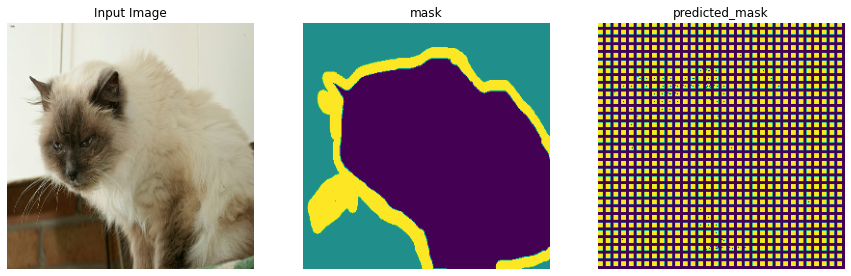

Epoch 2/10
41/41 [==============================] - 19s 405ms/step - loss: 0.9789 - accuracy: 0.4273 - val_loss: 0.9691 - val_accuracy: 0.4323


Epoch 3/10
41/41 [==============================] - 20s 430ms/step - loss: 0.9554 - accuracy: 0.4444 - val_loss: 0.9550 - val_accuracy: 0.4431


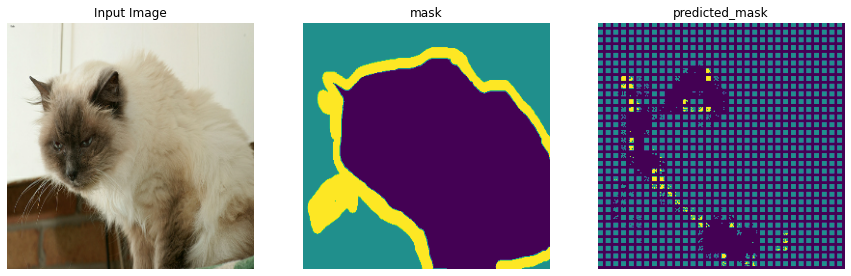

Epoch 4/10
41/41 [==============================] - 19s 408ms/step - loss: 0.9490 - accuracy: 0.4484 - val_loss: 0.9451 - val_accuracy: 0.4487


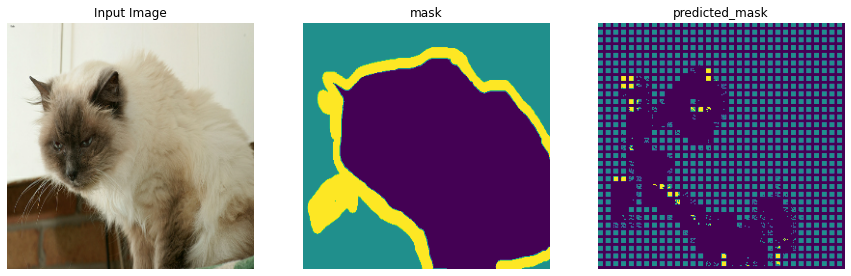

Epoch 5/10
41/41 [==============================] - 19s 400ms/step - loss: 0.9355 - accuracy: 0.4566 - val_loss: 0.9295 - val_accuracy: 0.4573


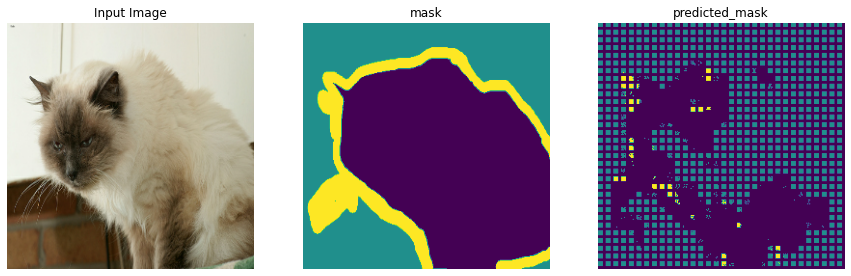

Epoch 6/10
41/41 [==============================] - 19s 408ms/step - loss: 0.9277 - accuracy: 0.4603 - val_loss: 0.9208 - val_accuracy: 0.4618


Epoch 7/10
41/41 [==============================] - 19s 407ms/step - loss: 0.9208 - accuracy: 0.4637 - val_loss: 0.9160 - val_accuracy: 0.4630


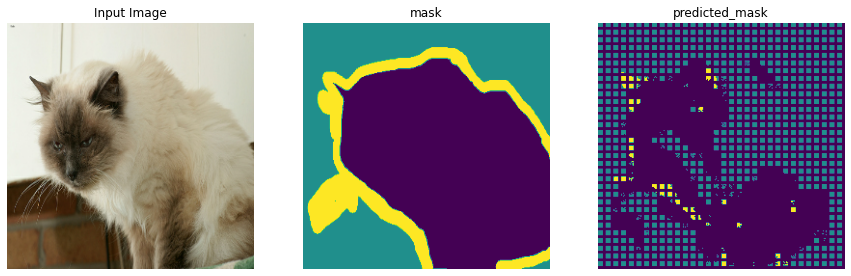

Epoch 8/10
41/41 [==============================] - 19s 407ms/step - loss: 0.9109 - accuracy: 0.4689 - val_loss: 0.9083 - val_accuracy: 0.4675


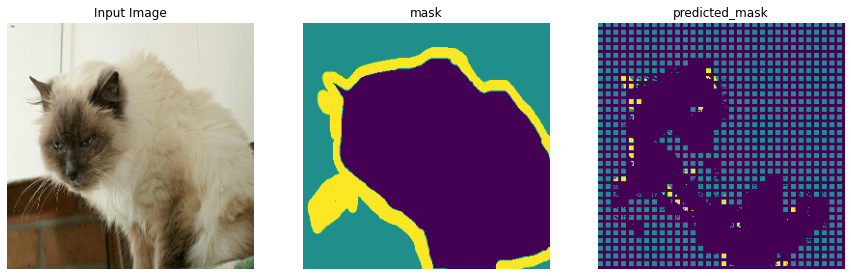

Epoch 9/10
41/41 [==============================] - 19s 409ms/step - loss: 0.9081 - accuracy: 0.4695 - val_loss: 0.9032 - val_accuracy: 0.4685


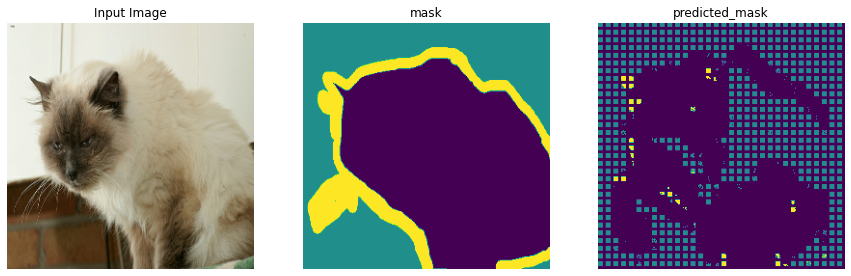

Epoch 10/10
41/41 [==============================] - 19s 408ms/step - loss: 0.9018 - accuracy: 0.4721 - val_loss: 0.9015 - val_accuracy: 0.4694


In [9]:
import matplotlib.pyplot as plt

# A function to display images and masks
def display_image_mask(image, mask, predicted_mask):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('mask')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask))
    plt.axis('off')

    # predicted_mask = tf.convert_to_tensor(predicted_mask)
    # The predicted mask currently gives probabilities; we take the argmax to get class values
    predicted_mask = tf.expand_dims(tf.argmax(predicted_mask, axis=-1), axis=-1)

    plt.subplot(1, 3, 3)
    plt.title('predicted_mask')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(predicted_mask))
    plt.axis('off')

    plt.show()

# A function to show visualize the prediction of the model on a number of images
# from the given dataset
def display_prediction(model, dataset, image_count):
  for image_batch, mask_batch in dataset.batch(image_count).take(1):
    predicted_mask_batch = model.predict(image_batch)
    for image, mask, predicted_mask in zip(image_batch, mask_batch, predicted_mask_batch):
      display_image_mask(image, mask, predicted_mask)


# A callback to visualize results during training
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    display_prediction(model, train_dataset, 1)

# define the optimizer and compile the model
adam = optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset.batch(batch_size), 
                    validation_data=validation_dataset.batch(batch_size),
                    epochs=epochs,
                    callbacks=[DisplayCallback()])


## 6. Visualize

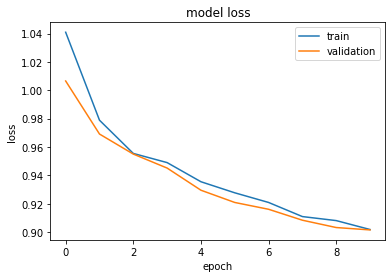

In [10]:
# plot train and validation loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show(); plt.close()


Train samples


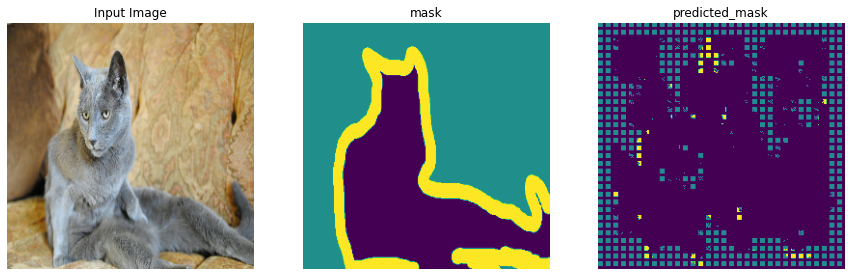

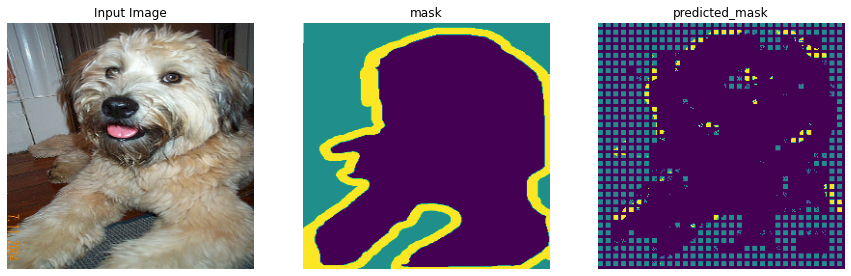

Validation samples


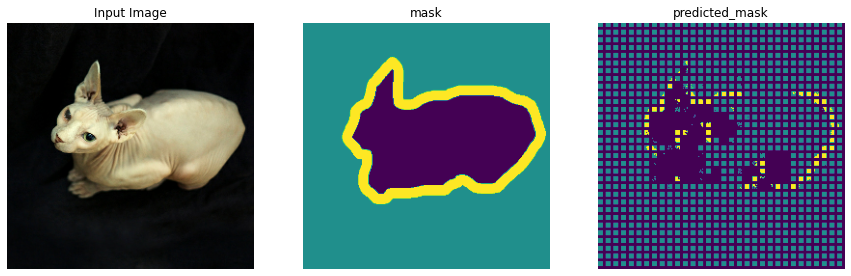

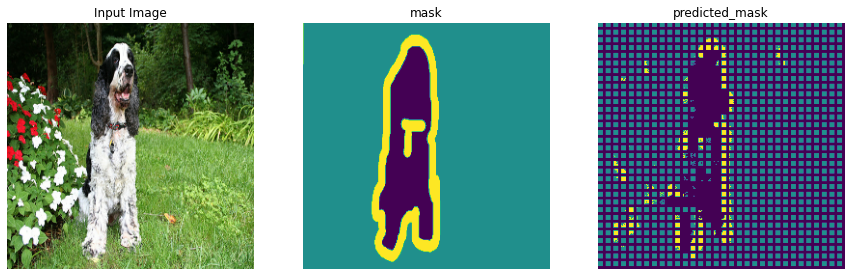

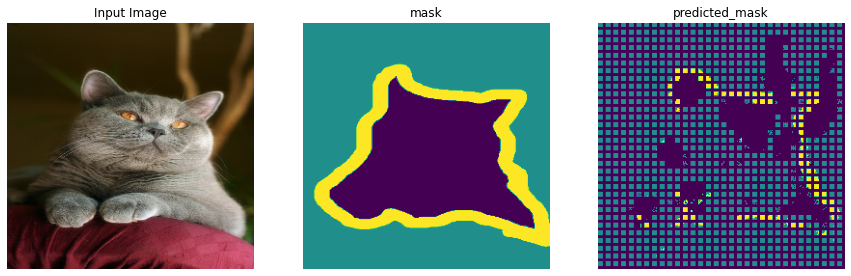

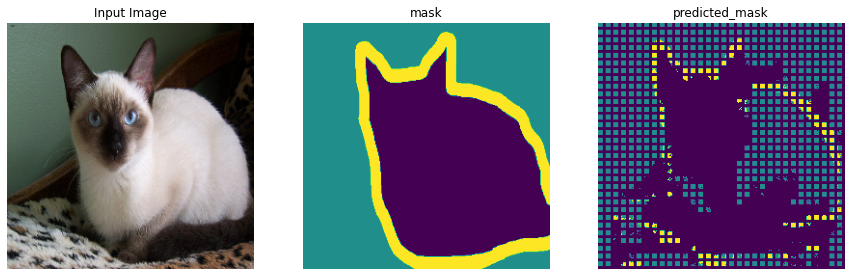

In [11]:
print('Train samples')
display_prediction(model, train_dataset, 4)

print('Validation samples')
display_prediction(model, validation_dataset, 4)


## 7. Model Evaluation

In [12]:
test_loss, test_acc = model.evaluate(test_dataset.batch(batch_size))

# Print results
print('test loss:', test_loss)
print('test accuracy:', test_acc)

58/58 [==============================] - 15s 255ms/step - loss: 0.9017 - accuracy: 0.4731
test loss: 0.9017015695571899
test accuracy: 0.4730699956417084


Test samples


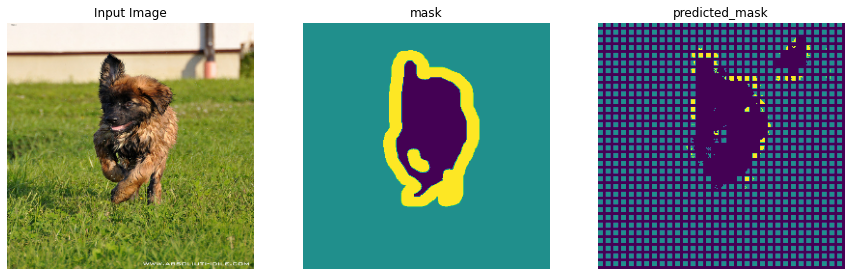

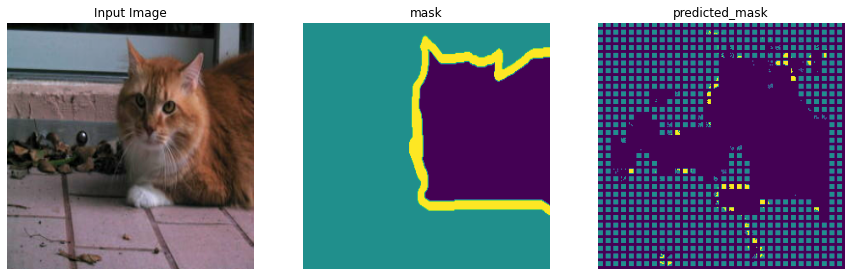

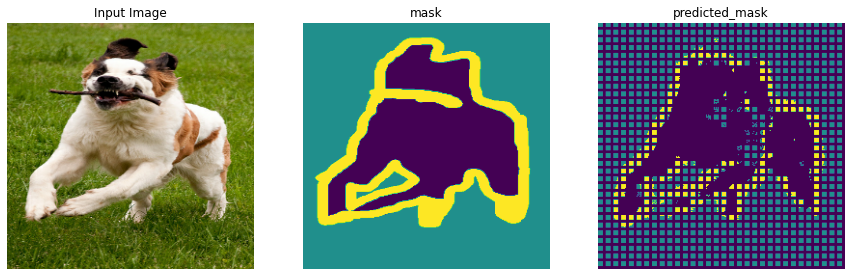

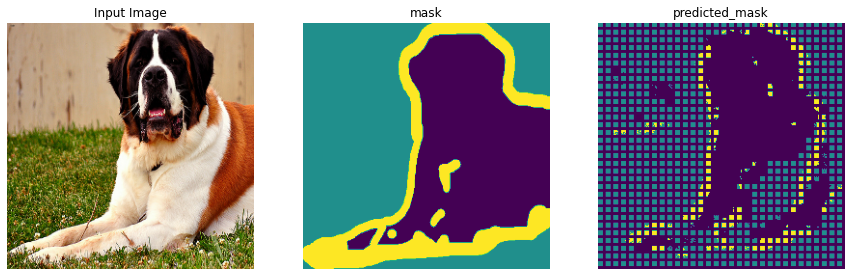

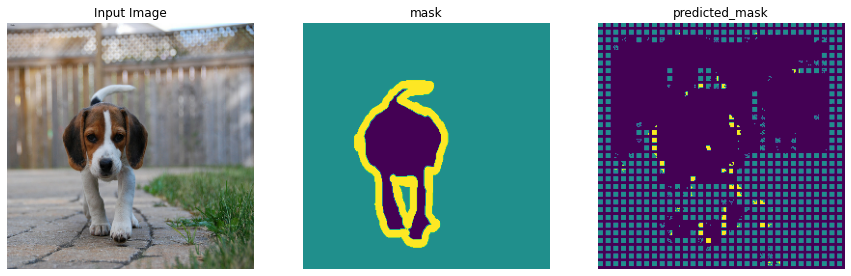

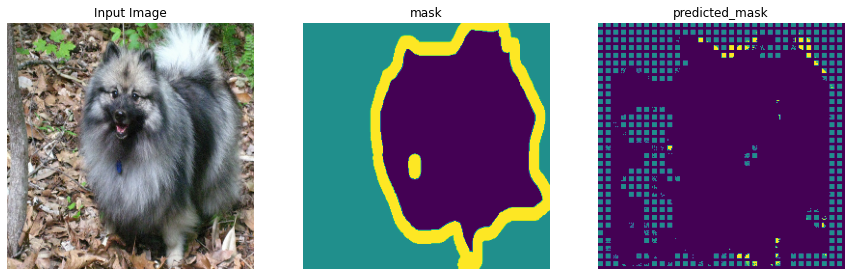

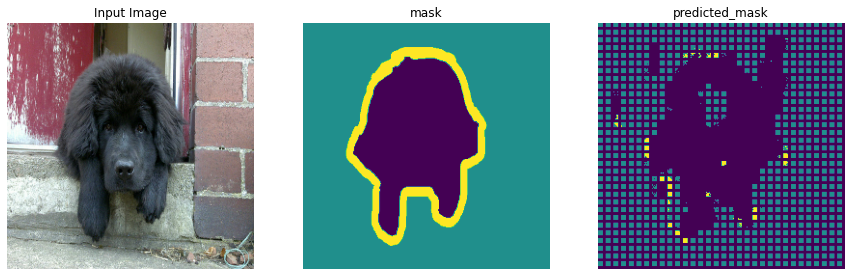

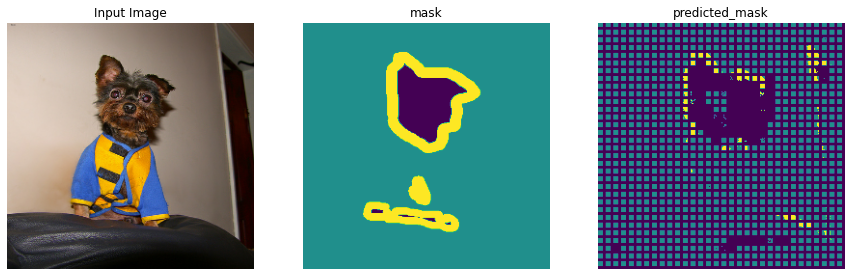

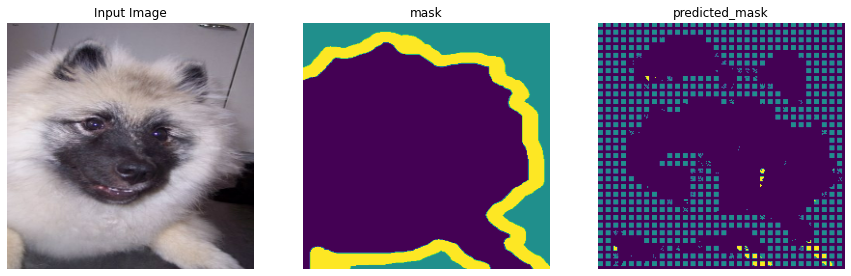

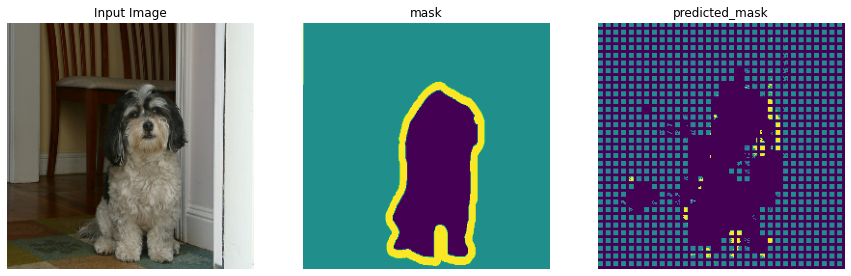

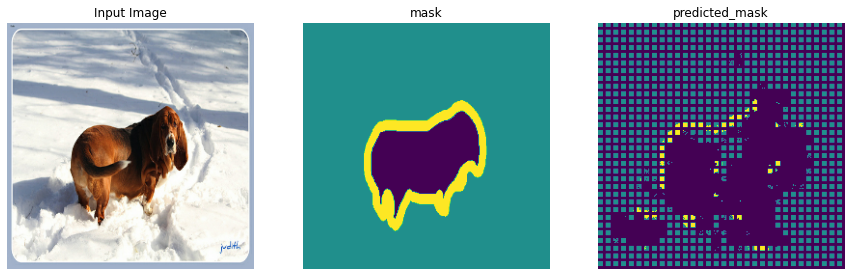

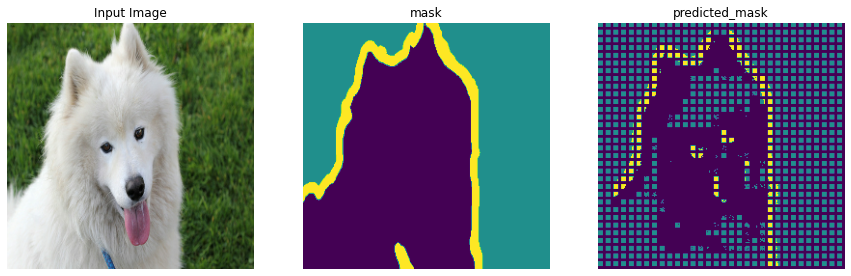

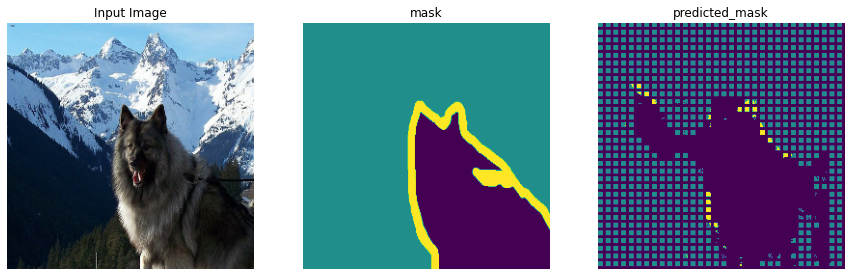

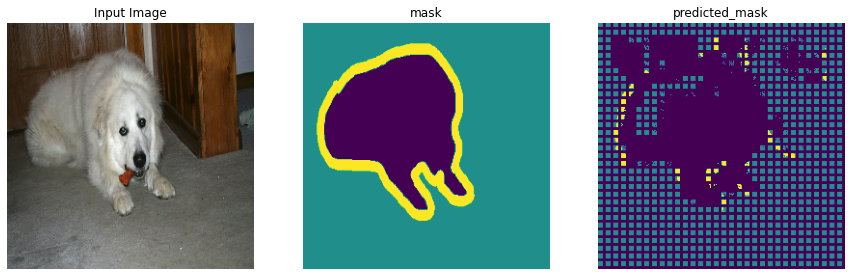

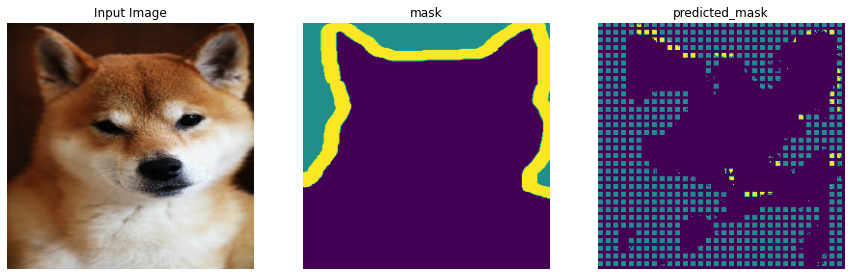

In [13]:
print('Test samples')
display_prediction(model, test_dataset, 16)
